In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.patches import Rectangle
from torchvision import datasets, transforms

import seaborn as sns  
from sklearn.manifold import TSNE

import vae_utils


# Variational Autoencoder for MNIST




## Load the dataset

In [2]:
mnist = True

def npy_loader(path):
    return torch.from_numpy(np.load(path))

device = 'cpu'
# device = 'cpu'  # uncomment this line to run the model on the CPU
batch_size = 128
if mnist:
    dataset = datasets.MNIST 
    if device == 'cuda':
        train_loader = torch.utils.data.DataLoader(
            dataset('data', train=True, download=True, transform=transforms.ToTensor()),
            batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True
        )
        test_loader = torch.utils.data.DataLoader(
            dataset('data', train=False, download=True, transform=transforms.ToTensor()),
            batch_size=1000, shuffle=True, num_workers=1, pin_memory=True
        )
    elif device == 'cpu':
        train_loader = torch.utils.data.DataLoader(
            dataset('data', train=True, download=True, transform=transforms.ToTensor()),
            batch_size=batch_size, shuffle=True,
        )
        test_loader = torch.utils.data.DataLoader(
            dataset('data', train=False, download=True, transform=transforms.ToTensor()),
            batch_size=1000, shuffle=True,
        )
else:
    tr = np.load("/Users/unstblecrsr/Desktop/Praktikum/exercise_4/tra/FireEvac_train_set.npy")
    tes = np.load("/Users/unstblecrsr/Desktop/Praktikum/exercise_4/tes/FireEvac_test_set.npy")
    tensor_tr = torch.from_numpy(tr) # transform to torch tensor
    tensor_tes = torch.from_numpy(tes)
     # create your datset
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(tensor_tr),
        batch_size=batch_size,
        shuffle=True,)
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(tensor_tes),
        batch_size=600, 
        shuffle=True,)
    

In [3]:
class VAE(nn.Module):
    def __init__(self, obs_dim, latent_dim, hidden_dim=100):
        """Initialize the VAE model.
        
        Args:
            obs_dim: Dimension of the observed data x, int
            latent_dim: Dimension of the latent variable z, int
            hidden_dim: Hidden dimension of the encoder/decoder networks, int
        """
        super().__init__()
        self.latent_dim = latent_dim
        # Trainable layers of the encoder
        self.linear1 = nn.Linear(obs_dim, hidden_dim)
        self.linear21 = nn.Linear(hidden_dim, latent_dim)
        self.linear22 = nn.Linear(hidden_dim, latent_dim)
        # Trainable layers of the decoder
        self.linear3 = nn.Linear(latent_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, obs_dim)
    
    def encoder(self, x):

        l1 = F.relu(self.linear1(x))
        mu = self.linear21(l1)
        logsigma = self.linear22(l1)
        
        return mu, logsigma

    
    def sample_with_reparam(self, mu, logsigma):

        sigma = torch.diag(torch.exp(logsigma) ** 2)
        normal_distt = torch.empty(sigma.shape).normal_(0,1)
        
        return normal_distt * sigma + mu
        

    
    def decoder(self, z):
        l1 = F.relu(self.linear3(z))
        theta = torch.sigmoid(self.linear4(l1))
        return theta

    
    def kl_divergence(self, mu, logsigma):
        sigma_squared = torch.exp(logsigma) ** 2
        return 0.5*torch.sum(mu**2 - 1 - logsigma*2 + sigma_squared, dim=1)
    
    def elbo(self, x):
        mu, logsigma = self.encoder(x)
        z_prime = self.sample_with_reparam(mu, logsigma)
        theta = self.decoder(z_prime)
        cross_entropy = torch.sum(F.binary_cross_entropy(theta, x, reduction='none'), dim=1)
        return - cross_entropy - self.kl_divergence(mu, logsigma)
        
        
    def sample(self, num_samples):
        normal_distt = torch.empty(num_samples, latent_dim).normal_(0,10)
        x = self.decoder(normal_distt)
        
        return x

In [7]:
obs_dim = 784  # MNIST images are of shape [1, 28, 28]
latent_dim = 32  # Size of the latent variable z
hidden_dim = 256  # Size of the hidden layer in the encoder / decoder

vae = VAE(obs_dim, latent_dim, hidden_dim).to(device)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)
losses = []

In [8]:
max_epochs = 20
display_step = 100
for epoch in range(max_epochs):
    print(f'Epoch {epoch}')
    for ix, batch in enumerate(train_loader):

        x, y = batch
        x = x.view(x.shape[0], obs_dim).to(device)  # we flatten the image into 1D array
        opt.zero_grad()
        # We want to maximize the ELBO, so we minimize the negative ELBO
        loss = -vae.elbo(x).mean(-1)
        loss.backward()
        opt.step()
        if ix % display_step == 0:
            print(f'  loss = {loss.item():.2f}')
    losses.append(loss.item())

Epoch 0
  loss = 552.75
  loss = 215.67
  loss = 212.35
  loss = 200.95
  loss = 190.24
Epoch 1
  loss = 186.61
  loss = 169.93
  loss = 157.45
  loss = 156.24


KeyboardInterrupt: 

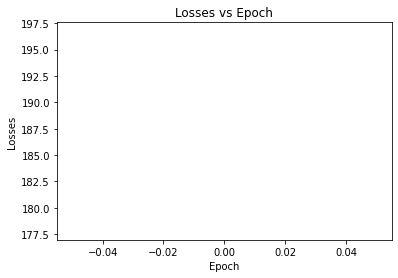

In [9]:
plt.plot(losses)
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.title('Losses vs Epoch')
plt.savefig("loss_ep_" + str(max_epochs)  + "latdim_" + str(latent_dim) + ".png")

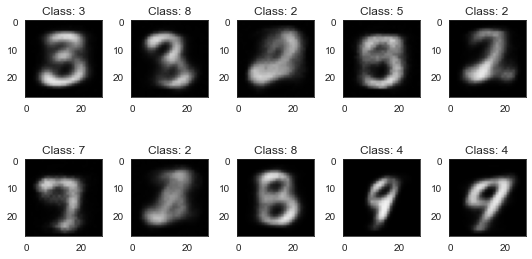

In [10]:

num_rows=2
num_cols=5
sns.set_style('white')
num_total = num_rows * num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5 * num_cols, 2 * num_rows))
for i in range(num_total):
    ax = axes[i // num_cols, i % num_cols]
    idx = np.random.randint(len(test_loader.dataset))
    x = test_loader.dataset[idx][0]
    y = test_loader.dataset[idx][1]
    x = x.view(x.shape[0], obs_dim).to(device)
    mu, logsigma = vae.encoder(x)
    z_prime = vae.sample_with_reparam(mu, logsigma)
    theta = vae.decoder(z_prime).view(-1, 28, 28).detach().cpu().numpy()[0]
    ax.imshow(theta, cmap='gray', vmin=0.0, vmax=1.0)
    ax.set_title(f'Class: {y}')
plt.tight_layout()
plt.savefig("GAR_rec_ep_" + str(max_epochs) + "latdim_" + str(latent_dim) + ".png")
plt.show()


### Visualize samples generated by the model

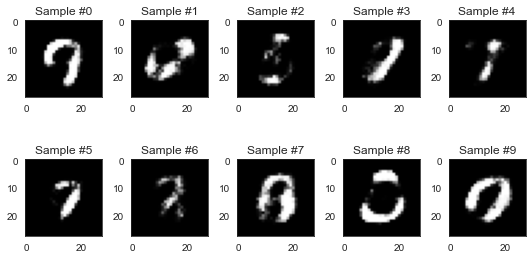

In [11]:
samples = vae.sample(10).view(-1, 28, 28).detach().cpu().numpy()
sns.set_style('white')
num_total = num_rows * num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5 * num_cols, 2 * num_rows))
for i in range(num_total):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(samples[i], cmap='gray', vmin=0.0, vmax=1.0)
    ax.set_title(f'Sample #{i}')
plt.tight_layout()
plt.savefig("GAR_gen_ep_" + str(max_epochs)+ "latdim_" + str(latent_dim) + ".png")
plt.show()


In [12]:
x, y = next(iter(test_loader))
x = x.view(x.shape[0], obs_dim).to(device)
plt.figure(figsize=[10, 7])
sns.set_style('whitegrid')
tsne = TSNE(init='pca')
# Obtain embeddings using VAE
means = vae.encoder(x)
# Dimensionality reduction on the embeddings using t-SNE
emb = tsne.fit_transform(means)

plt.figure(figsize=[10, 7])
labels = y.cpu().numpy()
for l in np.unique(labels):
    class_ind = (labels == l)
    plt.scatter(emb[class_ind, 0], emb[class_ind, 1], label=f'{l}', alpha=0.5)
    plt.legend()
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.savefig("GAR_lat_rep_ep_" + str(max_epochs)+ "latdim_" + str(latent_dim) + ".png")
plt.show()

ValueError: only one element tensors can be converted to Python scalars

<Figure size 720x504 with 0 Axes>